<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

#custom imports
import copy

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving Trump.JPG to Trump.JPG

Upload Style Image


Saving Gotye.JPG to Gotye.JPG
Content Path: <_io.BytesIO object at 0x7f2d545ce220>
Style Path: <_io.BytesIO object at 0x7f2d72100720>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


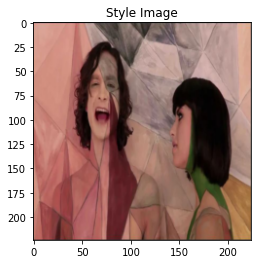

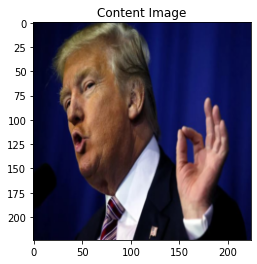

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if isinstance(m, nn.MaxPool2d):
          self.vgg[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
conv_indices = [0, 0, 5, 10, 17, 24]
content_indices = [0]
style_indices = [0, 5, 10, 17, 24]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
vgg_content = VGGIntermediate(content_indices).eval()
vgg_content.cuda()
vgg_style = VGGIntermediate(style_indices).eval()
vgg_style.cuda()

# Cache the outputs of the content and style layers for their respective images
vgg_content.p = vgg_content(content_image)
vgg_style.a = vgg_style(style_image)
print("-----------Content Image------------")
print(vgg_content.p)
print("------------Style Image-------------")
print(vgg_style.a)

<ipython-input-5-211d4f8e6962>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-5-211d4f8e6962>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior i

  0%|          | 0.00/528M [00:00<?, ?B/s]

-----------Content Image------------
{0: tensor([[[[-4.0748e-01,  2.7417e-01,  2.7913e-01,  ...,  4.9927e-01,
            4.9927e-01,  1.7536e+00],
          [-8.1875e-01,  2.0849e-01,  2.0201e-01,  ...,  2.5961e-01,
            2.5961e-01,  2.1324e+00],
          [-8.1875e-01,  2.1220e-01,  2.1577e-01,  ...,  2.5961e-01,
            2.5961e-01,  2.1324e+00],
          ...,
          [-7.8328e-01,  2.1773e-01,  2.1362e-01,  ...,  2.2579e-01,
            3.2814e-01,  1.6757e+00],
          [-7.7069e-01,  2.1325e-01,  2.0981e-01,  ...,  2.6694e-01,
            3.5381e-01,  1.6335e+00],
          [-8.4983e-01, -1.1101e-01, -1.1923e-01,  ..., -1.8507e-01,
           -1.2441e-01,  8.1994e-01]],

         [[-4.3427e+00, -6.7824e-02, -7.2650e-03,  ...,  5.2315e-01,
            5.2315e-01,  3.6601e+00],
          [-4.1301e+00,  3.9782e-01,  4.5276e-01,  ...,  3.7966e-01,
            3.7966e-01,  4.0838e+00],
          [-4.1301e+00,  4.2055e-01,  4.6675e-01,  ...,  3.7966e-01,
            3.796

___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [ ]:
# def gram_matrix(layer):
#   gram = torch.Tensor([]).cuda()
#   for i in range(len(layer)-1): #for each filter i
#     for j in range(i+1, len(layer)-1): #gram matrix i with filter j
#       gram = torch.cat((gram, torch.mul(layer[i], layer[j]).unsqueeze(0)), 0)
#   return gram

def gram_matrix(layer):
  b, c, h, w = layer.shape
  layer = layer.view( b*c, h*w)
  basis = torch.mm(layer, layer.t())
  return torch.div(basis, b*c*h*w)
  
class ContentLoss(nn.Module):
  def __init__(self, p_l):
    #p_l is a 3D tensor of all the 2d filters in a layer(l) of content image p
    super(ContentLoss, self).__init__()
    self.p_l = p_l.detach()
  
  def forward(self, f_l):
    #f_l is a 3D tensor of all the 2d filters in a layer(l) of generated image x
    # diff = torch.sub(f_l, self.p_l)
    # return torch.mul(.5, torch.mul(diff, diff))
    self.loss = F.mse_loss(f_l, self.p_l)
    return self.loss

    
class StyleLoss(nn.Module):
  def __init__(self, a_l):
    #w_l is a scalar weight for this layer's contribution to the total loss
    #a_l is a 3D tensor of all the 2d filters in a layer(l) of style image a
    super(StyleLoss, self).__init__()
    #self.w_l = w_l
    self.A_l = gram_matrix(a_l.detach())

  # def forward(self, g_l):
  #   N = len(g_l)
  #   M = len(g_l[0])*len(g_l[0][0])
  #   normalization_const = 1/(4*N**2*M**2)
  #   diff = torch.sub(gram_matrix(g_l), gram_matrix(self.a_l))
  #   return torch.mul(normalization_const, torch.mul(diff,diff))

  def forward(self, g_l):
    G_l = gram_matrix(g_l)
    self.loss = F.mse_loss(G_l, self.A_l)
    return self.loss

class TotalLoss(nn.Module):
  def __init__(self, alpha=1, beta=1e3):
    super(TotalLoss, self).__init__()
    self.content_module = ContentLoss(vgg_content.p[0])
    self.style_modules = nn.ModuleList([StyleLoss(vgg_style.a[key]) for key in vgg_style.a.keys()])
    self.alpha = alpha
    self.beta = beta
    self.content_losses = []
    self.style_losses = []
    self.store_every_n_iterations = 50

  def forward(self, x_content, x_style_layers, iteration=1):
    content_loss = self.content_module(x_content)
    style_loss = 0 #placeholder
    for index, module in enumerate(self.style_modules):
      #print("style shape: ", x_style_layers[index].shape)
      style_loss += module(x_style_layers[index])
    #print("content shape: ", content_loss.shape)
    #print("total style: ", style_loss.shape)
    if iteration % self.store_every_n_iterations == 0:
      self.content_losses.append(content_loss.item())
      self.style_losses.append(style_loss.item())
    return self.alpha * content_loss + self.beta*(1/len(self.style_modules)) * style_loss
    

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
#content_modules = 

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
#style_modules = 

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



In [ ]:
# Start with a copy of the content image
generated_image = content_image.clone().detach().requires_grad_(True)
# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
vgg_image = VGGIntermediate(conv_indices).eval()
vgg_image.cuda()

optimizer = optim.Adam([generated_image], lr=0.05)
objective = TotalLoss(alpha=1, beta=1e5)

num_iterations = 1000
loop = tqdm(total=num_iterations, position=0)
for iteration in range(num_iterations):
  generated_image.clamp(0,1)

  optimizer.zero_grad()

  x = vgg_image(generated_image)

  loss = objective(x[conv_indices[0]], [x[key] for key in x.keys()], iteration)

  mem = torch.cuda.memory_allocated() / 1e9
  loop.set_description('iteration:{} memory:{:.4f}'.format(iteration, mem))
  loop.update()

  loss.backward() #compute gradient
  optimizer.step() #use computed gradient
  


<ipython-input-5-211d4f8e6962>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-5-211d4f8e6962>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
iteration:999 memory:0.5589: 100%|█████████▉| 999/1000 [00:22<00:00, 44.04it/s]

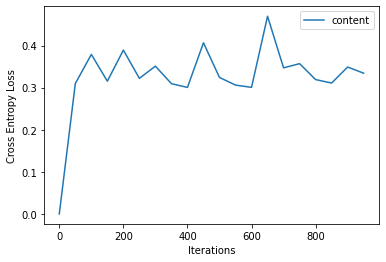

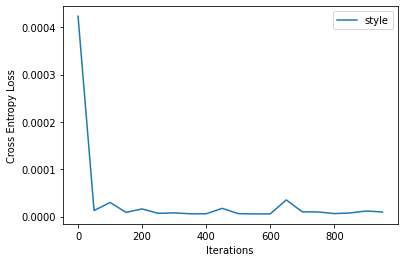

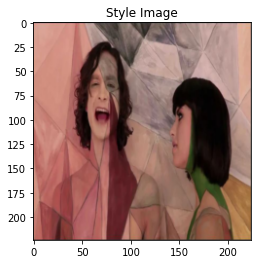

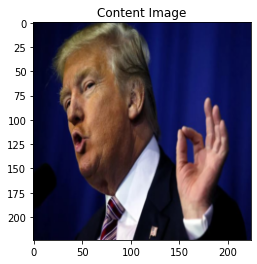

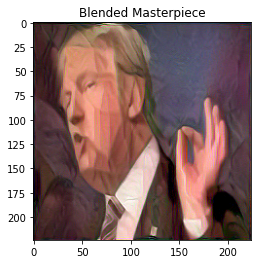

In [ ]:
# Show the image
#uncomment the lines below to see exact values for losses
# for iteration, loss in enumerate(objective.content_losses):
#   print("Iteration: ", iteration*objective.store_every_n_iterations)
#   print("content loss: ", loss)
#   print("style loss: ", objective.style_losses[iteration])
#graph the losses
plt.plot([objective.store_every_n_iterations*i for i in range(len(objective.content_losses))], objective.content_losses, label='content')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()
plt.plot([objective.store_every_n_iterations*i for i in range(len(objective.style_losses))], objective.style_losses, label='style')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()
#display images
plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

plt.figure()
display(generated_image.clamp(0,1), title='Blended Masterpiece')

### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Take the filter activations (P and F) of a layer from a model as you run an image (p) through it, then again as you run an altered image (x) through it. The content loss of the layer is equal to the mean squared error (the 1/2 and the exponent) of each cell (j) in each filter (i) in the image activation compared to its counterpart in the altered image activation. 


- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

A gram matrix is equal to the dot product between a flattened matrix (i) and another flattened matrix (j). This is what I understand the paper to be saying but is not at all what actually helped for the lab. I had to get help for that.

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

Make a Gram Matrix of the filter activations (A and G) of a layer from a model as you run an image (a) through it, then again as you run an altered image (x) through it. The Gram Matrix approach lets us see teh relationships between filter activations within the same layer. The style loss of the layer is equal to the mean squared error (the constant in front and the exponent) of each cell (j) in each filter (i) in the gram matrix compared to its counterpart in the second gram matrix. 
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

To compute the total style loss for the model, simply sum the style loss of each layer (El) multiplied by a weight (wl) for each layer (l). In the paper, each weight was equivalent.

**DONE:**